In [1]:
!rm -rf ./output
!mkdir ./output
!mkdir ./output/finalmodel

In [2]:
import numpy as np
import pandas as pd
import datasets
from datasets import load_metric

from matplotlib import pyplot as plt
from transformers import AutoFeatureExtractor, ResNetForImageClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split

import random
import os
import torch

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
input_dir='../input/digit-recognizer'
output_dir='./output'
model_id='microsoft/resnet-50'
img_size=28
metric=load_metric("accuracy")

In [4]:
def display_img(img_arr):
    plt.imshow(img_arr, interpolation='nearest')
    plt.show()

def img1d_to_img2d (imgs1d, imgX=28, imgY=28):
    img2d = []
    for img1d in imgs1d:
        img_reshape = np.reshape(img1d, (imgX, imgY))
        img2d.append(np.array([img_reshape, img_reshape, img_reshape]).transpose((1,2,0)))
    return np.array(img2d)

def img_pad (img, padding):
    return np.pad(img, padding, 'constant')

def gen_encoding(batch):
    inputs = feature_extractor([np.array(x) for x in batch['image']], return_tensors='pt')
    inputs['label'] = batch['label']
    return inputs

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [5]:
df = pd.read_csv(input_dir+'/train.csv')

train, test = train_test_split(df, train_size=0.8)
test, val = train_test_split(test, train_size=0.5)

print(train.shape)
print(test.shape)
print(val.shape)

(33600, 785)
(4200, 785)
(4200, 785)


In [6]:
train_Y = train.to_numpy()[:, 0]
train_X = img1d_to_img2d(train.to_numpy()[:, 1:])

test_Y = test.to_numpy()[:, 0]
test_X = img1d_to_img2d(test.to_numpy()[:, 1:])

val_Y = val.to_numpy()[:, 0]
val_X = img1d_to_img2d(val.to_numpy()[:, 1:])


print(train_Y.shape)
print(train_X.shape)
print(test_Y.shape)
print(test_X.shape)
print(val_Y.shape)
print(val_X.shape)

(33600,)
(33600, 28, 28, 3)
(4200,)
(4200, 28, 28, 3)
(4200,)
(4200, 28, 28, 3)


In [7]:
train_ds = datasets.Dataset.from_dict({'image': train_X, 'label': train_Y})
pt_train = train_ds.with_transform(gen_encoding)

test_ds = datasets.Dataset.from_dict({'image': test_X, 'label': test_Y})
pt_test = test_ds.with_transform(gen_encoding)

val_ds = datasets.Dataset.from_dict({'image': val_X, 'label': val_Y})
pt_val = val_ds.with_transform(gen_encoding)

In [8]:
labels = np.unique(train_Y)
labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

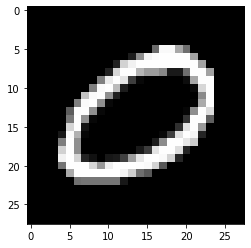

In [9]:
display_img(train_X[0])

In [10]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id, size=img_size)

Downloading:   0%|          | 0.00/266 [00:00<?, ?B/s]

In [11]:
model = ResNetForImageClassification.from_pretrained(model_id,
                                                     num_labels=len(labels),
                                                     ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/97.8M [00:00<?, ?B/s]

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([10, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
training_args = TrainingArguments(
  output_dir=output_dir,
  evaluation_strategy="steps",
  per_device_train_batch_size=64,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
#     data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=pt_train,
    eval_dataset=pt_test
)

In [14]:
train_results = trainer.train()
trainer.save_model(f'{output_dir}/finalmodel')
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 33600
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1575


Step,Training Loss,Validation Loss,Accuracy
100,1.890300,1.877047,0.429286
200,1.360300,1.289231,0.639524
300,0.900200,0.804012,0.777857
400,0.570900,0.514002,0.860952
500,0.438400,0.316008,0.916190
600,0.301100,0.225666,0.936667
700,0.276600,0.175840,0.949762
800,0.250200,0.142528,0.957857
900,0.203700,0.123754,0.961667
1000,0.257200,0.113040,0.969524


***** Running Evaluation *****
  Num examples = 4200
  Batch size = 8
Saving model checkpoint to ./output/checkpoint-100
Configuration saved in ./output/checkpoint-100/config.json
Model weights saved in ./output/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4200
  Batch size = 8
Saving model checkpoint to ./output/checkpoint-200
Configuration saved in ./output/checkpoint-200/config.json
Model weights saved in ./output/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4200
  Batch size = 8
Saving model checkpoint to ./output/checkpoint-300
Configuration saved in ./output/checkpoint-300/config.json
Model weights saved in ./output/checkpoint-300/pytorch_model.bin
Deleting older checkpoint [output/checkpoint-100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 4200
  Batch size = 8
Saving model checkpoint to ./output/checkpoint-400
Configuration saved in ./output/checkpoint-400/config.json
Model 

***** train metrics *****
  epoch                    =        3.0
  total_flos               = 31170507GF
  train_loss               =     0.5162
  train_runtime            = 0:11:48.21
  train_samples_per_second =     142.33
  train_steps_per_second   =      2.224


In [15]:
metrics = trainer.evaluate(pt_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 4200
  Batch size = 8


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =      0.975
  eval_loss               =     0.0865
  eval_runtime            = 0:00:18.55
  eval_samples_per_second =    226.369
  eval_steps_per_second   =     28.296


In [16]:
model_id = './output/finalmodel/'
model = ResNetForImageClassification.from_pretrained(model_id)

loading configuration file ./output/finalmodel/config.json
Model config ResNetConfig {
  "_name_or_path": "microsoft/resnet-50",
  "architectures": [
    "ResNetForImageClassification"
  ],
  "depths": [
    3,
    4,
    6,
    3
  ],
  "downsample_in_first_stage": false,
  "embedding_size": 64,
  "hidden_act": "relu",
  "hidden_sizes": [
    256,
    512,
    1024,
    2048
  ],
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_type": "bottleneck",
  "model_type": "resnet",
  "num_channels": 3,
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.20.1"
}

load

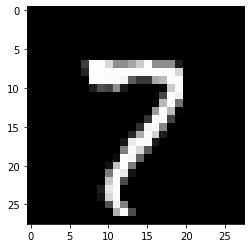

7


In [17]:
idx=random.randint(0, len(val_X))
display_img(val_X[idx])

inputs = feature_extractor(val_X[idx], return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(predicted_label)